In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,f1_score, mean_squared_error,mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg,AR
import json
import arviz as az
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pymc3 as pm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
import random
import theano.tensor as tt
import theano
from statsmodels.tsa.arima.model import ARIMA

In [4]:
baseline_df=pd.read_csv('/kaggle/input/new-data-climate-pop1/new_data_climate_pop.csv')
baseline_df['date']=pd.to_datetime(baseline_df['date'])
baseline_df=(baseline_df.set_index('date',drop=True)).sort_values('state')
baseline_df_ca=baseline_df[baseline_df['state']=='CA']['2020-05-10':'2022-06-01']
baseline_df_ca['school_mode'] = baseline_df_ca['school_mode'].round().astype('float')
baseline_df_ca['elderly_mode'] = baseline_df_ca['elderly_mode'].round().astype('float')
mapping = {0: 'no_policy', 1: 'low_policy', 2: 'med_policy', 3: 'high_policy'}
baseline_df_ca['elderly_mode'] = baseline_df_ca['elderly_mode'].astype(int).map(mapping)
baseline_df_ca['school_mode'] = baseline_df_ca['school_mode'].astype(int).map(mapping)
baseline_df_ca = pd.get_dummies(baseline_df_ca, columns=['elderly_mode'], prefix='elderly_mode')
baseline_df_ca = pd.get_dummies(baseline_df_ca, columns=['school_mode'], prefix='school_mode')
baseline_df_ca['ILIp_lag']=baseline_df_ca['ILIp'].shift(1)
baseline_df_ca.dropna(inplace=True)


In [5]:
with pm.Model() as hierarchical_model:
            #PRIORS
    b_resid_av7= pm.Normal('resid_av7', mu=0., sigma=1)
    b_gp_av7= pm.Normal('gp_av7', mu=0., sigma=1)
    b_transit_av7= pm.Normal('transit_av7', mu=0., sigma=1)
    b_work_av7= pm.Normal('work_av7', mu=0., sigma=1)

    b_masking= pm.Normal('b_masking', mu=0., sigma=1)
    b_school_low= pm.Normal('b_school_low', mu=0., sigma=1)
    b_school_med= pm.Normal('b_school_med', mu=0., sigma=1)
    b_school_high= pm.Normal('b_school_high', mu=0., sigma=1)
    b_elderly_med= pm.Normal('b_elderly_med', mu=0., sigma=1)
    b_elderly_high= pm.Normal('b_elderly_high', mu=0., sigma=1)

    b_ili_lag_1 = pm.Normal(f'ili_lag_1', mu=0, sigma=1)
    a = pm.Normal(f'alpha', mu=0, sigma=1)
    formula= (a + b_ili_lag_1*baseline_df_ca['ILIp_lag'] + b_masking*baseline_df_ca['mask']
                + b_resid_av7*baseline_df_ca['resid_av7']  + b_gp_av7*baseline_df_ca['gp_av7']
              + b_transit_av7*baseline_df_ca['transit_av7']  + b_work_av7*baseline_df_ca['work_av7'])
    
    formula+=(b_school_low * baseline_df_ca['school_mode_low_policy'] +b_school_med * baseline_df_ca['school_mode_med_policy']
                            + b_school_high * baseline_df_ca['school_mode_high_policy'])
    formula+=(b_elderly_med * baseline_df_ca['elderly_mode_med_policy']+ b_elderly_high * baseline_df_ca['elderly_mode_high_policy'])
    sigma = pm.HalfNormal('sigma', sd=1)   
    pm.Normal(f'y_like', mu=formula,sigma=sigma,observed=baseline_df_ca['ILIp'])
    trace=pm.sample(draws=1000, tune=1000,cores=1)

In [6]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
resid_av7,-0.000,0.000,-0.000,-0.000,0.000,0.000,41.0,55.0,1.06
gp_av7,0.000,0.000,-0.000,0.000,0.000,0.000,16.0,79.0,1.12
transit_av7,-0.000,0.000,-0.000,-0.000,0.000,0.000,37.0,52.0,1.07
work_av7,-0.000,0.000,-0.000,-0.000,0.000,0.000,37.0,56.0,1.05
b_masking,-0.004,0.001,-0.005,-0.003,0.000,0.000,61.0,121.0,1.03
b_school_low,-0.350,0.277,-0.661,0.010,0.193,0.165,2.0,14.0,2.72
b_school_med,-0.350,0.277,-0.662,0.009,0.193,0.165,2.0,14.0,2.72
b_school_high,-0.350,0.277,-0.662,0.009,0.193,0.165,2.0,14.0,2.72
b_elderly_med,0.144,0.293,-0.307,0.643,0.190,0.159,3.0,21.0,1.97
b_elderly_high,0.146,0.293,-0.302,0.648,0.190,0.160,3.0,21.0,1.97


0.6249817133848532


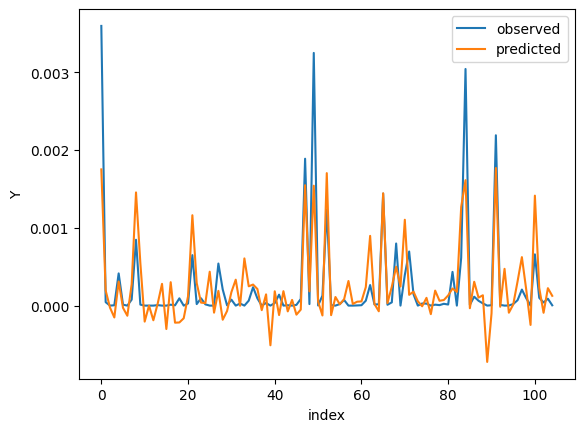

In [10]:
predictions = pm.sample_posterior_predictive(trace, samples=1000, model=hierarchical_model)
pred=predictions['y_like']
mean_pred=pred.mean(axis=0)
observed=baseline_df_ca['ILIp'].values
r2 = r2_score(observed, mean_pred)
print(r2)
plt.plot(observed,label='observed')
plt.plot(mean_pred,label='predicted')
plt.ylabel('Y')
plt.xlabel('index')

plt.legend()